# Week 12 Notebook: Save and Package Model for Deployment
The goal of this week's assignment is to deploy the model and develop a monitoring plan, discussing whether data drift and concept drift impact the data.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
import pickle

Index(['datetime', 'timestamp', 'hour', 'day', 'month', 'timezone', 'source',
       'destination', 'cab_type', 'product_id', 'name', 'price', 'distance',
       'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax

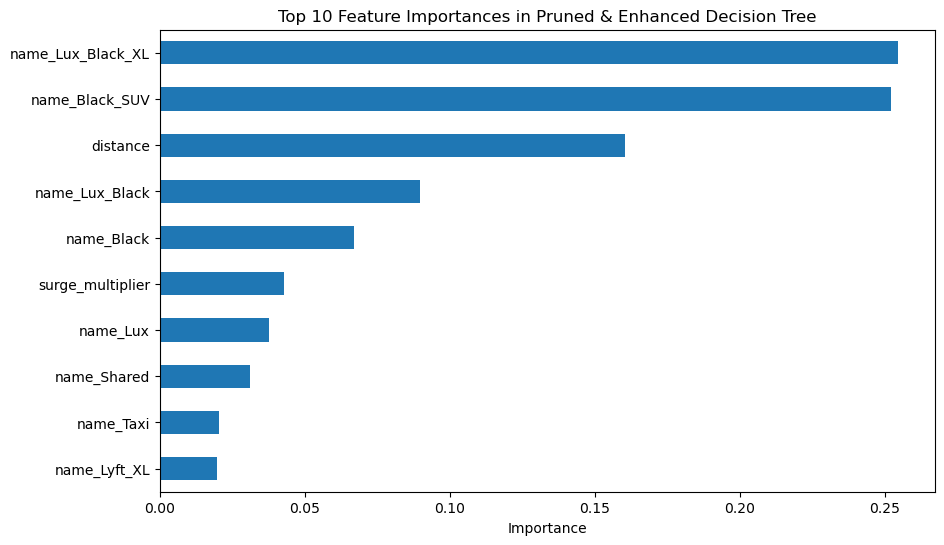

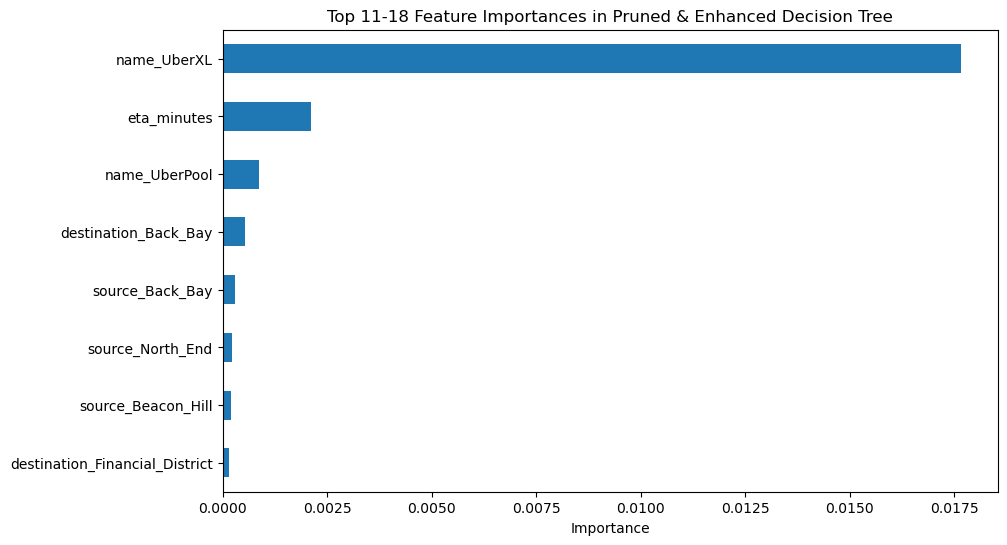

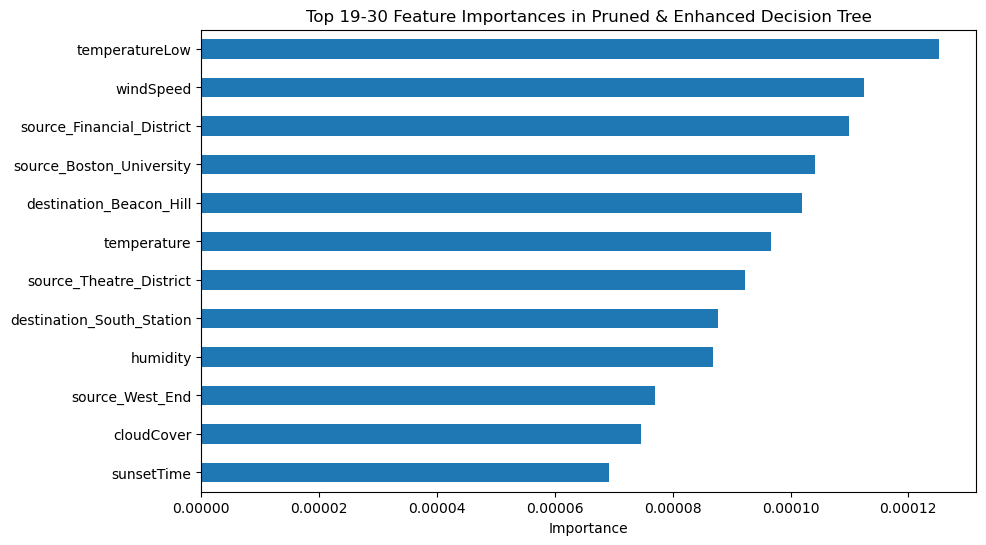

MSE Bias Analysis for Top 10 Important Features:
              Feature  Group         MSE
0   name_Lux_Black_XL   0.00    3.056295
1   name_Lux_Black_XL   1.00    4.213786
2      name_Black_SUV   0.00    2.994843
3      name_Black_SUV   1.00    4.735759
4      name_Lux_Black   1.00    3.011131
5      name_Lux_Black   0.00    3.152120
6          name_Black   0.00    3.164492
7          name_Black   1.00    2.880146
8    surge_multiplier   1.00    2.933532
9    surge_multiplier   1.25    5.515025
10   surge_multiplier   2.00   19.045349
11   surge_multiplier   1.50    7.250132
12   surge_multiplier   1.75   17.827029
13   surge_multiplier   3.00  203.062500
14   surge_multiplier   2.50   40.038496
15           name_Lux   0.00    3.198494
16           name_Lux   1.00    2.410509
17        name_Shared   0.00    3.175447
18        name_Shared   1.00    2.739856
19          name_Taxi   0.00    3.275010
20          name_Taxi   1.00    1.594805
21       name_Lyft_XL   0.00    3.222075
22      

In [2]:
%run "week11_notebook.ipynb"

### Serializing the model with pickle

In [4]:
def save_model(model, file_path):
    """
    Serialize and save the model to a file.
    Dependencies: pickle
    """
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {file_path}")

def load_model(file_path):
    """
    Load the serialized model from a file.
    Dependencies: pickle
    """
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {file_path}")
    return model

### Saving and loading the data

In [5]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

model_folder = os.path.join(parent_dir,"models")
data_folder = os.path.join(parent_dir,"data")

raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

In [6]:
# Paths for feature variables
X_train_path = os.path.join(processed_data_folder, 'X_train.parquet')
X_val_path = os.path.join(processed_data_folder, 'X_val.parquet')
X_test_path = os.path.join(processed_data_folder, 'X_test.parquet')

# Paths for the target variables
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

# Paths for models
model_path = os.path.join(model_folder, 'final_model.pkl')


In [7]:
# Save cleaned data to CSV
def save_data(df, file_path):
    """
    Save a DataFrame to a CSV file.
    Dependencies: pandas
    """
    df.to_parquet(file_path, index=False)
    print(f"Data saved to {file_path}")

def load_data(file_path):
    """
    Load data from a CSV file into a DataFrame.
    Dependencies: pandas
    """
    df = pd.read_parquet(file_path)
    print(f"Data loaded from {file_path}")
    return df


In [8]:
# Save the cleaned training data
save_data(rh_X_train_scaled, X_train_path)
save_data(rh_X_val_scaled, X_val_path)
save_data(rh_X_test_scaled, X_test_path)

# Save the retrained pruned decision tree model
save_model(dtr_rh_cleaned, model_path)

Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_train.parquet
Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_val.parquet
Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_test.parquet
Model saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/models/final_model.pkl


In [9]:
# Load the saved model and data for verification
loaded_model = load_model(model_path)
loaded_data = load_data(X_train_path)

Model loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/models/final_model.pkl
Data loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_train.parquet


### Evaluate the loaded model on the test set

In [10]:
loaded_data.columns

Index(['hour', 'day', 'month', 'distance', 'surge_multiplier', 'temperature',
       'apparentTemperature', 'precipIntensity', 'precipProbability',
       'humidity', 'windSpeed', 'windGust', 'windGustTime', 'visibility',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'sunriseTime', 'sunsetTime',
       'moonPhase', 'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime',
       'weather_severity', 'rush_hour', 'weekend', 'game_day', 'eta_minutes',
       'source_Back_Bay', 'source_Beacon_Hill', 'source_Boston_University',
       'source_Fenway

In [11]:
# Test the loaded model on the test set
X_test = load_data(X_test_path)
y_test = load_data(y_test_path)
loaded_y_test_pred = loaded_model.predict(X_test)
loaded_test_mse, loaded_test_rmse, loaded_test_r2 = evaluate_model(rh_y_test, loaded_y_test_pred)

# Print evaluation metrics for the loaded model
print("\nEvaluation of Loaded Model:")
print(f"MSE: {loaded_test_mse:.4f}, RMSE: {loaded_test_rmse:.4f}, R²: {loaded_test_r2:.4f}")

Data loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_test.parquet
Data loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/y_test.parquet

Evaluation of Loaded Model:
MSE: 3.8990, RMSE: 1.9746, R²: 0.9534
